## Explore and Calculate Metrics for fb one

Here we calculate metrics for final post-processed boxes and can look at how those metrics change with other steps in the post processing, if you want to.

In [1]:
# which metric file?
binary_dirs = 'binaries_model6_tfrecordz/'

use_valid = True

# do we want to save our results to .dat files for use in other areas (like tables in latex)
save_dats = True
#any extra tag to anything
adder_dats = ''
# which iou's to save?
ioustar = [0.9] # fig, caption
scorestar = 0.1

adder = ''

pp2 = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/binaries_model6_tfrecordz_valid_fbdetect.pickle'

In [2]:
if use_valid: adder = '_valid'

How do we want to quantify how well we are doing?

In [3]:
n_folds_cv = 5 # for calculating the spread in our metrics, we we'll do a CV
scoreminVec = [0.1, 0.5, 0.9] # list of minimum box "scores"
iouminVec = [0.1, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95] # list of IOU cut offs we want to explore

# other classes
other_classes = ['text', 'title', 'list', 'table', 'figure']

In [79]:
import pickle
from sys import path
path.append('../')
import config
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from PIL import Image
import cv2 as cv
from metric_utils import calc_base_metrics_allboxes_cv, calc_prec_rec_f1_cv, print_metrics_table, \
  get_years_dataframe

In [5]:
# # debugging
# import metric_utils
# reload(metric_utils)
# from metric_utils import calc_base_metrics_allboxes_cv,calc_metrics

In [6]:
# # build up filename
pp = config.metric_results_dir
pp += binary_dirs.split('/')[0]
pp += adder
pp += '.pickle'

with open(pp, 'rb') as ff:
    icombo,imgs_name, truebox, pdfboxes, pdfrawboxes, captionText_figcap,\
                 bbox_figcap_pars,\
                 sboxes_cleaned, slabels_cleaned, sscores_cleaned,\
                 boxes_pdf, labels_pdf, scores_pdf,\
                 boxes_heur, labels_heur, scores_heur,\
                 boxes_heur2, labels_heur2, scores_heur2,\
                 boxes_par_found, labels_par_found, scores_par_found,\
                 boxes_sq1, labels_sq1, scores_sq1,\
                 boxes_sq2, labels_sq2, scores_sq2,\
                 boxes_sq3, labels_sq3, scores_sq3,\
                 boxes_sq4, labels_sq4, scores_sq4,\
                 boxes_sq5, labels_sq5, scores_sq5,\
                 truebox1,truebox2,truebox3,rotatedImage,LABELS,boxes1, scores1, labels1 = pickle.load(ff)
    
with open(pp2, 'rb') as ff:
    img_names_fb,boxes_fb,classes_fb,scores_fb,height,width = pickle.load(ff)

In [7]:
LABELS

['figure', 'figure caption', 'math formula', 'table']

Combine into true/found combos:

In [8]:
inames2 = []; bfb = []; cfb = []; scs = []
for im,b,c,s,h,w in zip(img_names_fb,boxes_fb,classes_fb,scores_fb,height,width):
    xx = np.array(b)
    if len(xx) > 0:
        xx = xx.reshape(xx.shape[0],xx.shape[2])
    else:
        xx = np.array([])
    inames2.append(im.split('/')[-1].split('.jpeg')[0])
    cc = np.array(c).flatten()
    cc2 = []; x22 = []; sc = []; 
    for x,ccc,ss in zip(xx,cc,s): # loop and re-index
        if other_classes[ccc] == 'figure':
            cc2.append(LABELS.index('figure'))
            x1 = x[0]/w*config.IMAGE_W
            y1 = x[1]/h*config.IMAGE_H
            x2 = x[2]/w*config.IMAGE_W
            y2 = x[3]/h*config.IMAGE_H
            x22.append(np.array([x1,y1,x2,y2]))
            sc.append(ss[0])
            
    # loop and find possible fig caption
    caps = []; caps_box = []; cap_s = []
    x23 = []
    for figb in x22:
        capd = 1e20; iind = -1
        for ii,(x,ccc,ss) in enumerate(zip(xx,cc,s)): # loop and re-index    
            if other_classes[ccc] == 'text':
                x1 = x[0]/w*config.IMAGE_W
                y1 = x[1]/h*config.IMAGE_H
                x2 = x[2]/w*config.IMAGE_W
                y2 = x[3]/h*config.IMAGE_H   
                xc = 0.5*(x1+x2); yc = 0.5*(y2+y1)
                xf = 0.5*(figb[0]+figb[2]); yf = 0.5*(figb[1]+figb[3])
                d = np.sqrt( (xc-xf)**2 + (yc-yf)**2 )
                if d < capd:
                    iind = ii
                    
        xarr = np.array(xx[iind])
        x23.append(np.array([xarr[0]/w*config.IMAGE_W,xarr[1]/h*config.IMAGE_H, 
                             xarr[2]/w*config.IMAGE_W,xarr[3]/h*config.IMAGE_H]))
        sc.append(s[iind][0])
        cc2.append(LABELS.index('figure caption'))
                   
        #import sys; sys.exit()      
            
    #import sys; sys.exit()
    x22.extend(x23)
            
    bfb.append(x22)
    cfb.append(cc2)
    scs.append(sc)
        
df1 = pd.DataFrame({'name':inames2, 'found_fb':bfb, 'classes_fb':cfb, 'scores_fb':scs})

In [9]:
inames1 = []
for im in imgs_name:
    inames1.append(im.split('/')[-1].split('.npz')[0])
    
df2 = pd.DataFrame({'name':inames1, 'found':boxes_sq5, 'classes':labels_sq5, 'true':truebox3})

In [10]:
#dfall = df1.merge(df2, on='name', how='inner')
dfall = df1.set_index('name').join(df2.set_index('name'))

In [11]:
dfall

,found_fb,classes_fb,scores_fb,found,classes,true
name,,,,,,
1996ApJ___467L_117B_p1,"[[282.2792156862745, 48.72426610569601, 458.56...","[0, 0, 1, 1]","[0.99653566, 0.99635905, 0.9402007, 0.9402007]","[[266.64156862745097, 451.33353639963445, 476....","[1, 0, 1, 0]","[[266.4407843137255, 180.59579652756625, 476.6..."
1990ApJS___73__401L_p14,"[[94.58743259803921, 40.27984375, 393.20370098...","[0, 1]","[0.9951244, 0.96782506]","[[56.420392156862746, 278.80727272727273, 443....","[1, 0]","[[56.420392156862746, 278.80727272727273, 443...."
1986ApJ___304__599H_p9,[],[],[],[],[],[]
1991ApJ___372___97C_p8,"[[256.7611029411765, 46.30879261363636, 464.40...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[0.9930108, 0.9927072, 0.98671895, 0.9682541, ...","[[49.995294117647056, 185.71636363636364, 215....","[1, 0, 1, 0, 1, 0, 1, 0]","[[256.40156862745096, 209.76484848484847, 465...."
1974ApJ___191__111S_p4,"[[55.726642156862745, 49.6384375, 443.45485294...","[0, 1]","[0.96634555, 0.81187654]","[[434.4972549019608, 56.32, 448.95372549019606...","[1, 0]","[[434.4972549019608, 56.32, 448.95372549019606..."
...,...,...,...,...,...,...
1993AJ____106_1005D_p3,"[[56.950686274509806, 44.82598011363636, 447.7...","[0, 1]","[0.9974058, 0.97796154]","[[266.03921568627453, 397.96363636363634, 441....","[1, 0]","[[64.65254901960785, 396.41212121212124, 239.3..."
1993ApJ___406__723B_p5,"[[26.105741421568627, 41.78382481724033, 242.0...","[0, 0, 1, 1]","[0.99482685, 0.99462354, 0.9300947, 0.9300947]","[[29.31450980392157, 171.86232104782212, 237.9...","[1, 0, 1, 0, 2]","[[29.31450980392157, 171.86232104782212, 237.9..."
1996AJ____112_2567F_p9,"[[72.85769607843137, 42.506174242424244, 438.8...","[0, 1]","[0.99563086, 0.5544405]","[[430.481568627451, 78.66181818181818, 436.906...","[1, 0]","[[430.481568627451, 78.66181818181818, 436.906..."


Show a random example:

In [73]:
ind = np.random.randint(0,len(dfall), 1)[0]

In [81]:
dfall.iloc[ind]

found_fb      [[48.26078125, 88.2375, 461.62916666666666, 32...
classes_fb                                               [0, 1]
scores_fb                               [0.9981469, 0.99729794]
found         [[55.21568627450981, 324.8872727272727, 454.57...
classes                                                  [1, 0]
true          [[55.21568627450981, 324.8872727272727, 454.57...
Name: 1979ApJ___232__129J_p10, dtype: object

In [82]:
img.shape

(3300, 2550, 3)

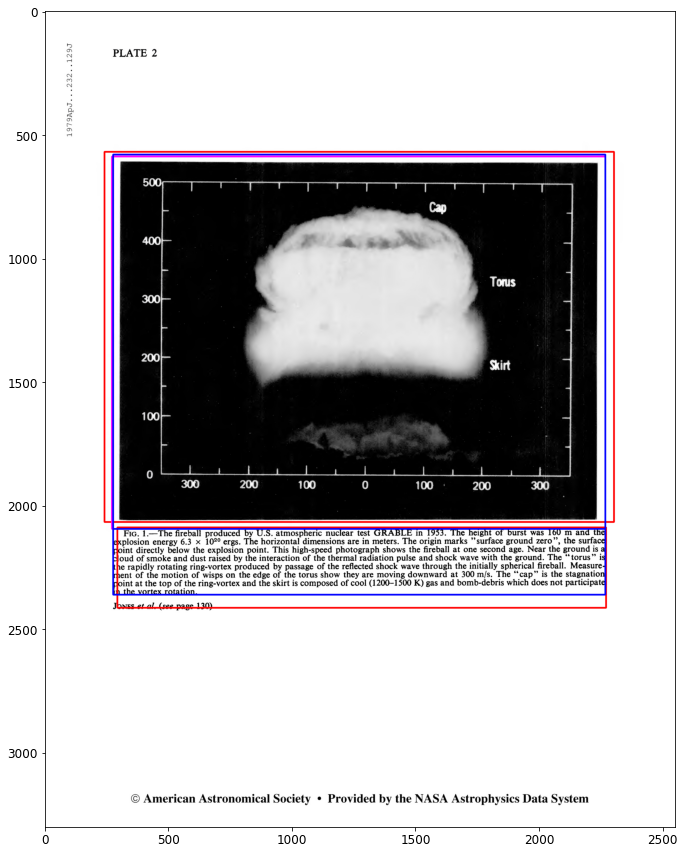

In [88]:
img = np.array(Image.open(config.images_jpeg_dir+ dfall.iloc[ind].name+'.jpeg').convert('RGB'))

#overplot squares

fig, ax = plt.subplots(1,1,figsize=(15,15))

for fb in dfall.iloc[ind]['found_fb']:
    xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
    xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
    ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
    ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
    cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (255, 0, 0), 5)  
    
for fb in dfall.iloc[ind]['found']:
    xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
    xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
    ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
    ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
    cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (255, 0, 255), 5)  

for fb in dfall.iloc[ind]['true']:
    xmin1 = fb[0]/config.IMAGE_W*img.shape[1]
    xmax1 = fb[2]/config.IMAGE_W*img.shape[1]
    ymin1 = fb[1]/config.IMAGE_H*img.shape[0]
    ymax1 = fb[3]/config.IMAGE_H*img.shape[0]
    cv.rectangle(img, (round(xmin1), round(ymin1)), (round(xmax1),round(ymax1)), (0, 0, 255), 5)  

ax.imshow(img)

plt.show()

In [12]:
dfall.iloc[0]['found_fb']

[array([282.27921569,  48.72426611, 458.56411765, 174.87100213]),
 array([274.31504902, 325.21809321, 467.69397059, 445.76176515]),
 array([ 36.03248162, 467.76785714, 248.03566176, 488.83250838]),
 array([ 36.03248162, 467.76785714, 248.03566176, 488.83250838])]

In [13]:
trueshere = np.array(dfall['true'].values).tolist(); boxes_fb = dfall['found_fb'].values.tolist(); 
labels_fb = dfall['classes_fb'].values.tolist(); scores_fb = dfall['scores_fb'].values.tolist()

In [14]:
#scores_fb[:3]

In [15]:
#scores_sq5[:3]

In [16]:
TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
                                              trueshere,boxes_fb,labels_fb, 
                                              scores_fb,n_folds_cv=n_folds_cv)

In [17]:
config.metric_results_dir

'/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/MetricsResults/'

Final box analytics:

In [18]:
# TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,scoreminVec,iouminVec,
#                                               truebox3,boxes_sq5,labels_sq5, 
#                                               scores_sq5,n_folds_cv=n_folds_cv)

In [19]:
TPv.shape

(4, 3, 8, 5)

Shape is: (# labels, #scores, #ious, #CV folds)

Calculate precision, recall, F1 (ignore /0 warnings, taken care of):

In [20]:
precision, precision_std, recall, \
  recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
                                               LABELS,scoreminVec,
                                               iouminVec)

Plot and check it out!

/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


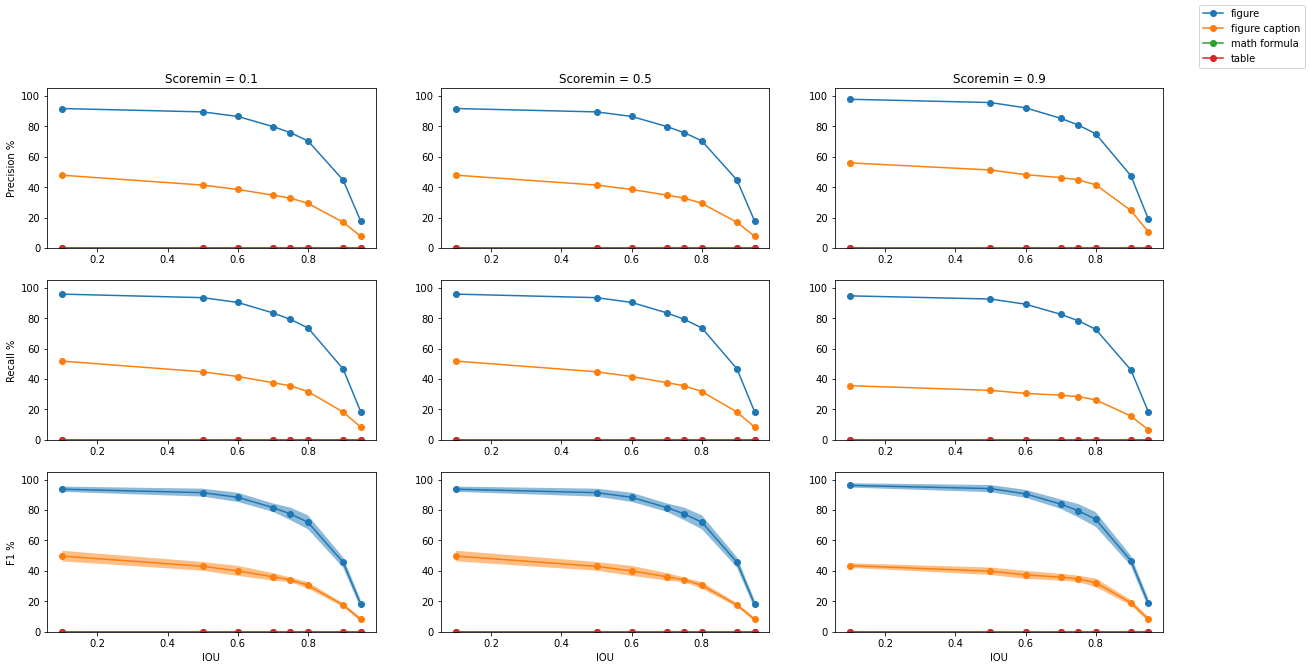

In [21]:
if len(scoreminVec) == 1:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(10,10))
    ax = np.array([ax,ax]).T
else:
    fig, ax = plt.subplots(3,len(scoreminVec),  figsize=(20,10))

ps = []
for i in range(len(scoreminVec)):
    for k in range(len(LABELS)): p1, = ax[0][i].plot(iouminVec,precision[k,i,:],'o-')
    ps.append(p1)
    ax[0][i].set_title('Scoremin = '+str(scoreminVec[i]))
    ax[0][0].set_ylabel('Precision %')
    ax[0][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): ax[1][i].plot(iouminVec,recall[k,i,:], 'o-')
    ax[1][0].set_ylabel('Recall %')
    ax[1][i].set_ylim(0,105)
    
    for k in range(len(LABELS)): 
        ax[2][i].plot(iouminVec,f1[k,i,:], 'o-')
        # include stddev
        ax[2][i].fill_between(iouminVec, f1[k,i,:]-f1_std[k,i,:], f1[k,i,:]+f1_std[k,i,:], alpha=0.5)
    
    ax[2][0].set_ylabel('F1 %')
    ax[2][i].set_ylim(0,105)
        
    ax[-1][i].set_xlabel('IOU')

fig.legend(ps, labels=LABELS)
matplotlib.rcParams.update({'font.size': 12})
plt.show()

Choose a score cut-off.  For the most part, we've found 0.1 to be fine:

In [51]:
scoremin = 0.95

What IOU cut-offs for each label? for reference:

In [52]:
LABELS

['figure', 'figure caption', 'math formula', 'table']

In [53]:
ioumin_per_label = [0.9, 0.95, 0.8, 0.6] # fig, fig+caption, math formula, table

In [54]:
#Shape is: (# labels, #scores, #ious, #CV folds)
# TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
#                                               truebox3,boxes_sq5,labels_sq5, 
#                                               scores_sq5,n_folds_cv=n_folds_cv)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],ioumin_per_label,
                                              trueshere,boxes_fb,labels_fb, 
                                              scores_fb,n_folds_cv=n_folds_cv)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

In [55]:
precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               ioumin_per_label)
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

In [56]:
print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, ioumin_per_label)

SCORE =  0.95  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.9             0.95            0.8             0.6            
# of objs       799             772             205             126            
--------------------------------------------------------------------------------------------
TP              44.7%           6.5%            0.0%            0.0%           
FP              48.4%           46.4%           0.0%            0.0%           
FN              55.3%           93.5%           100.0%          100.0%         
--------------------------------------------------------------------------------------------
Precision       47.8+/-4.4%     12.3+/-1.4%     0.0+/-0.0%      0.0+/-0.0%     
Recall          44.5+/-4.7%     6.5+/-1.0%      0.0+/-0.0%      0.0+/-0.0%     
F1              46.1+/-4.6%     8.5+/-1.1%      0.0+/-0.0%      0.0+/-0.0%     


In [57]:
#Shape is: (# labels, #scores, #ious, #CV folds)
TPs, FPs, FNs, totalTrues = calc_base_metrics_allboxes_cv(LABELS,[scoremin],[0.8,0.8,0.8,0.8],
                                              trueshere,boxes_fb,labels_fb, 
                                              scores_fb,n_folds_cv=n_folds_cv)
totalTrue = totalTrues.sum(axis=1).astype('int') # collapse onto 1 axis
TP = np.diagonal(TPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FP = np.diagonal(FPs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU
FN = np.diagonal(FNs[:,0,:,:].sum(axis=2)) # sum across all CV, then for the right IOU

precisions, precision_stds, recalls, \
  recall_stds, f1s, f1_stds = calc_prec_rec_f1_cv(TPs,FPs,FNs,
                                               LABELS,[scoremin],
                                               [0.8,0.8,0.8,0.8])
precision = np.diagonal(precisions[:,0,:]) 
precision_std = np.diagonal(precision_stds[:,0,:]) 
recall = np.diagonal(recalls[:,0,:]) 
recall_std = np.diagonal(recall_stds[:,0,:]) 
f1 = np.diagonal(f1s[:,0,:]) 
f1_std = np.diagonal(f1_stds[:,0,:]) 

print_metrics_table(totalTrue,TP,FP,FN,
                        precision, precision_std, recall, recall_std,f1,f1_std,
                        LABELS, scoremin, n_folds_cv, [0.8,0.8,0.8,0.8])

SCORE =  0.95  N_CV =  5
Metric          figure          figure caption  math formula    table          
iou cut         0.8             0.8             0.8             0.8            
# of objs       799             772             205             126            
--------------------------------------------------------------------------------------------
TP              71.1%           24.2%           0.0%            0.0%           
FP              22.0%           28.6%           0.0%            0.0%           
FN              28.9%           75.8%           100.0%          100.0%         
--------------------------------------------------------------------------------------------
Precision       76.3+/-2.9%     45.7+/-4.9%     0.0+/-0.0%      0.0+/-0.0%     
Recall          71.1+/-4.3%     24.2+/-4.0%     0.0+/-0.0%      0.0+/-0.0%     
F1              73.6+/-3.4%     31.6+/-4.5%     0.0+/-0.0%      0.0+/-0.0%     


## Vs. Time
Also, let's plot metrics vs. year.

In [58]:
# pick a min score and a min IOU
scoremin = 0.95
ioumin = 0.8

In [59]:
df = get_years_dataframe(imgs_name,scoremin,ioumin,LABELS,
                       trueshere,boxes_fb,labels_fb, 
                                              scores_fb)

In [60]:
df.head()

,years,total:figure,total:figure caption,total:math formula,total:table,TP:figure,TP:figure caption,TP:math formula,TP:table,FP:figure,FP:figure caption,FP:math formula,FP:table,FN:figure,FN:figure caption,FN:math formula,FN:table
0,1895-01-01,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1896-01-01,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1897-01-01,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1898-01-01,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0
4,1900-01-01,2.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [61]:
sampleHist = '10Y' # 5 years

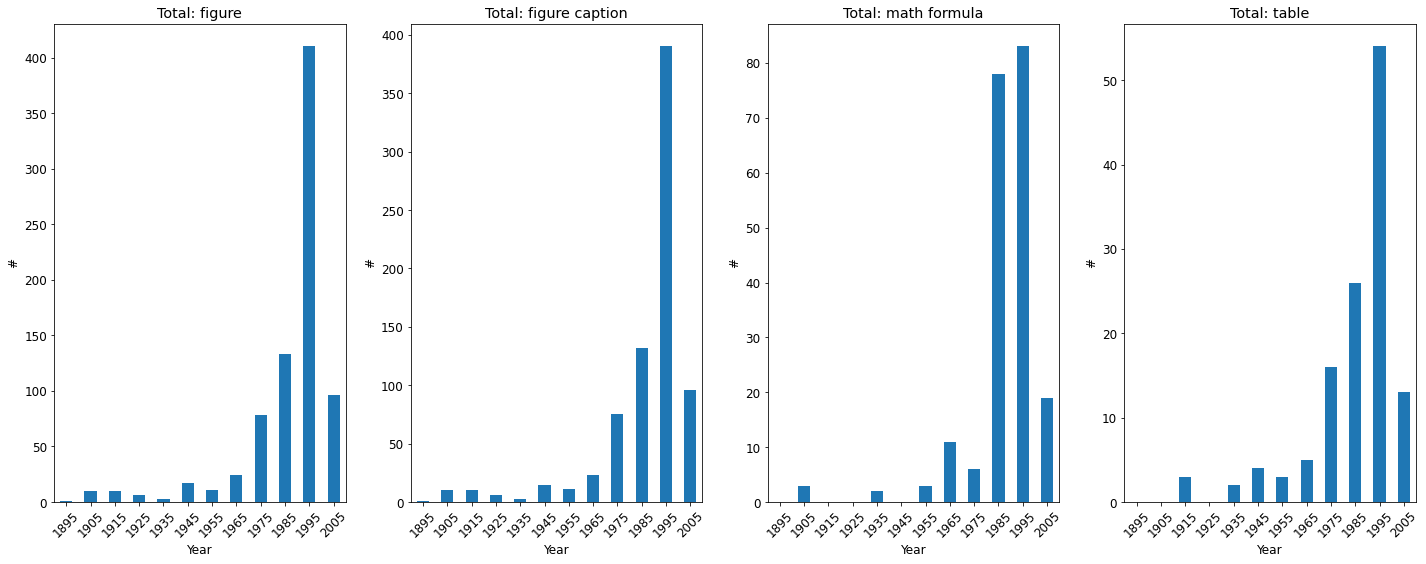

In [62]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    quant = pd.Series(index=df['years'],data=np.array(df['total:'+l])).resample(sampleHist).sum()
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Total: ' + l)
    ax[il].set_ylabel('#')
    ax[il].set_xlabel('Year')
#plt.show()

plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_articles_per_year.png')

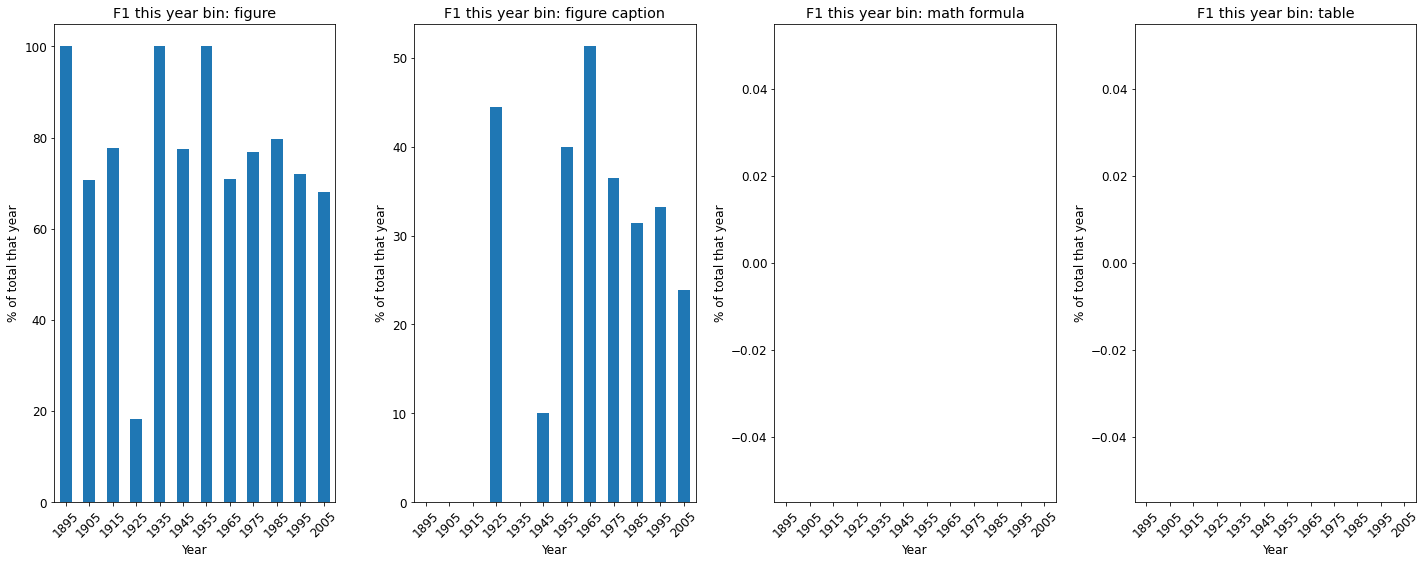

In [63]:
# loop and plot
qname = 'F1:'
bname = 'total:'
qlabel = 'F1'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    tp = pd.Series(index=df['years'],data=np.array(df['TP:'+l])).resample(sampleHist).sum()
    fp = pd.Series(index=df['years'],data=np.array(df['FP:'+l])).resample(sampleHist).sum()
    fn = pd.Series(index=df['years'],data=np.array(df['FN:'+l])).resample(sampleHist).sum()
    p = tp/(tp+fp); r = tp/(tp+fn)
    quant = 100*(2.0*r*p)/(r+p)
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' this year bin: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

Some other metrics:

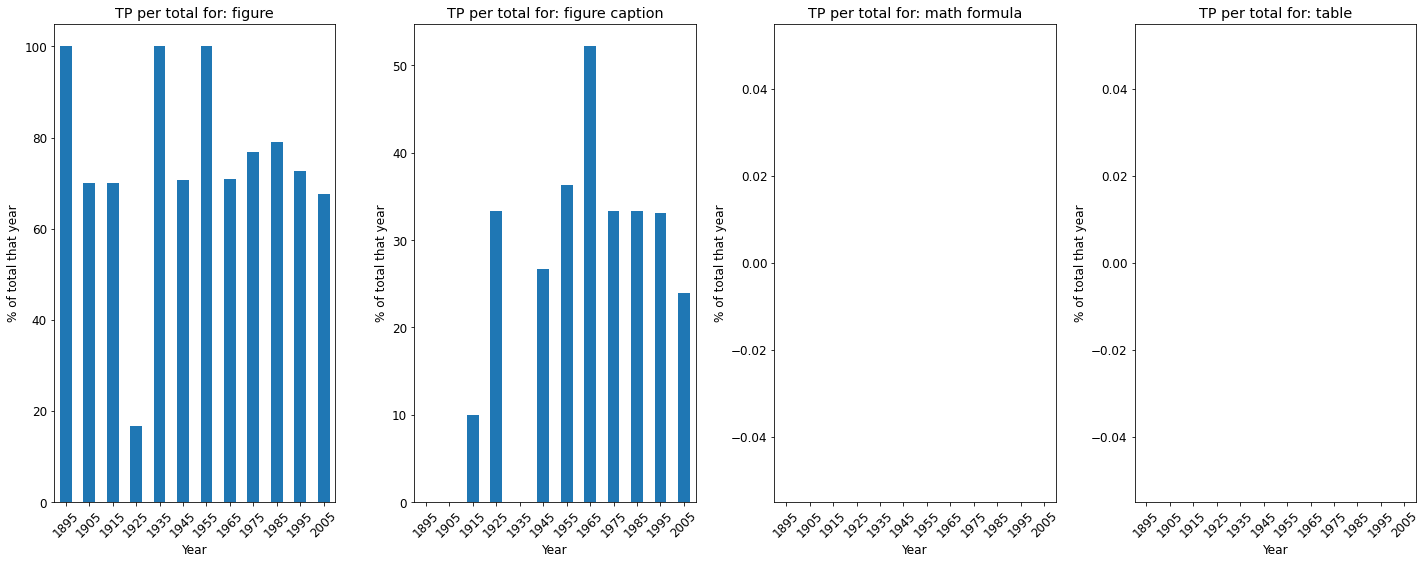

In [39]:
# loop and plot
qname = 'TP:'
bname = 'total:'
qlabel = 'TP'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
#plt.show()
plt.tight_layout()
#plt.savefig(saveFigDir+'yolo_noOCR_truePositives_per_year.png')

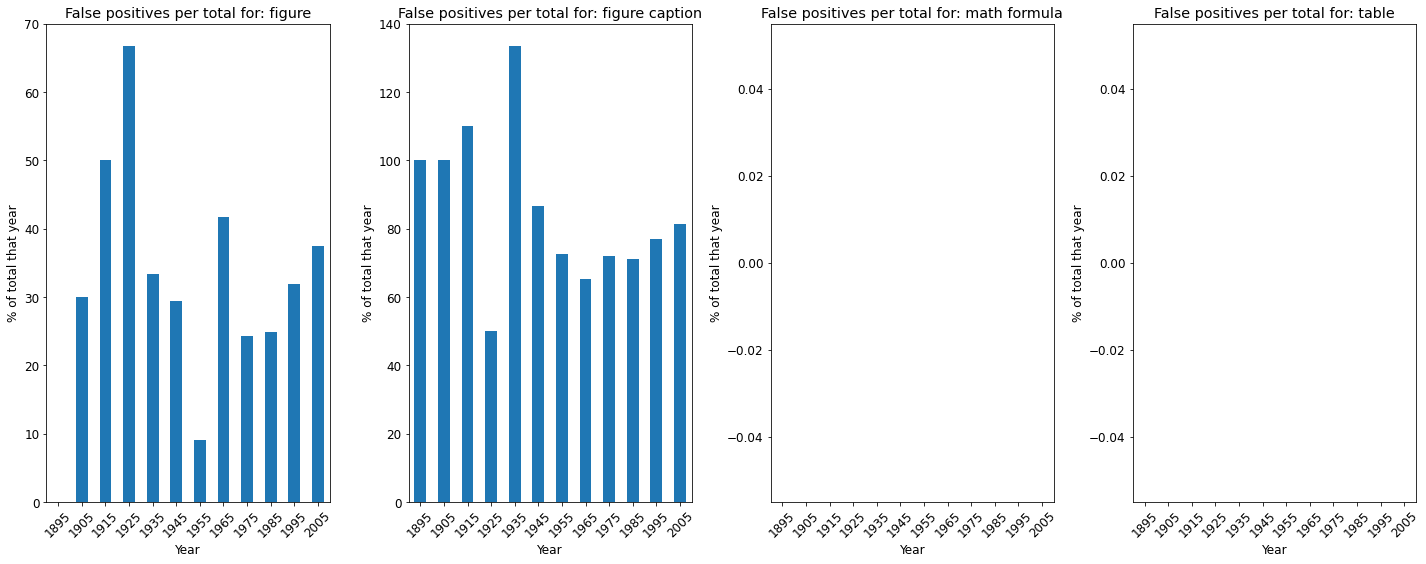

In [40]:
# loop and plot
qname = 'FP:'
bname = 'total:'
qlabel = 'False positives'
#fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))
matplotlib.rcParams.update({'font.size': 12})

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
    
plt.tight_layout()
plt.show()

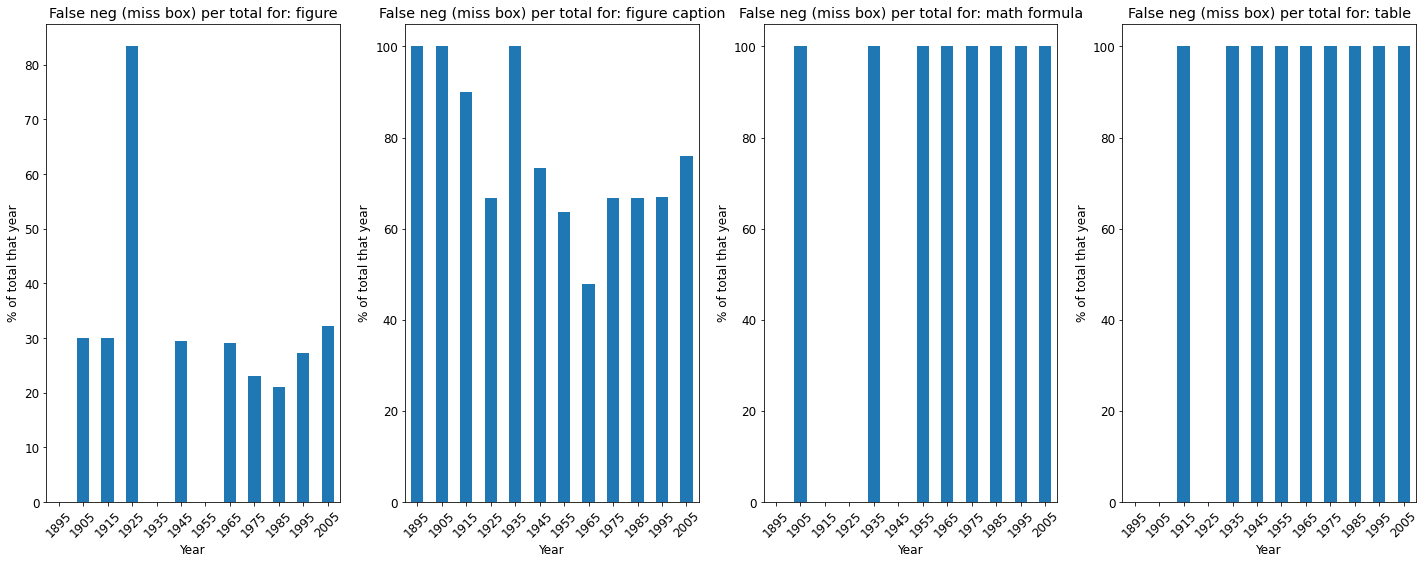

In [41]:
# loop and plot
qname = 'FN:'
bname = 'total:'
qlabel = 'False neg (miss box)'
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    counts = pd.Series(index=df['years'],data=np.array(df[qname+l])).resample(sampleHist).sum()
    tot = pd.Series(index=df['years'],data=np.array(df[bname+l])).resample(sampleHist).sum()
    with np.errstate(invalid='ignore'): # take care of zeros later
        quant = pd.Series(index=tot.index,data=np.array(100*counts.values/tot.values))
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title(qlabel+' per total for: ' + l)
    ax[il].set_ylabel('% of total that year')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

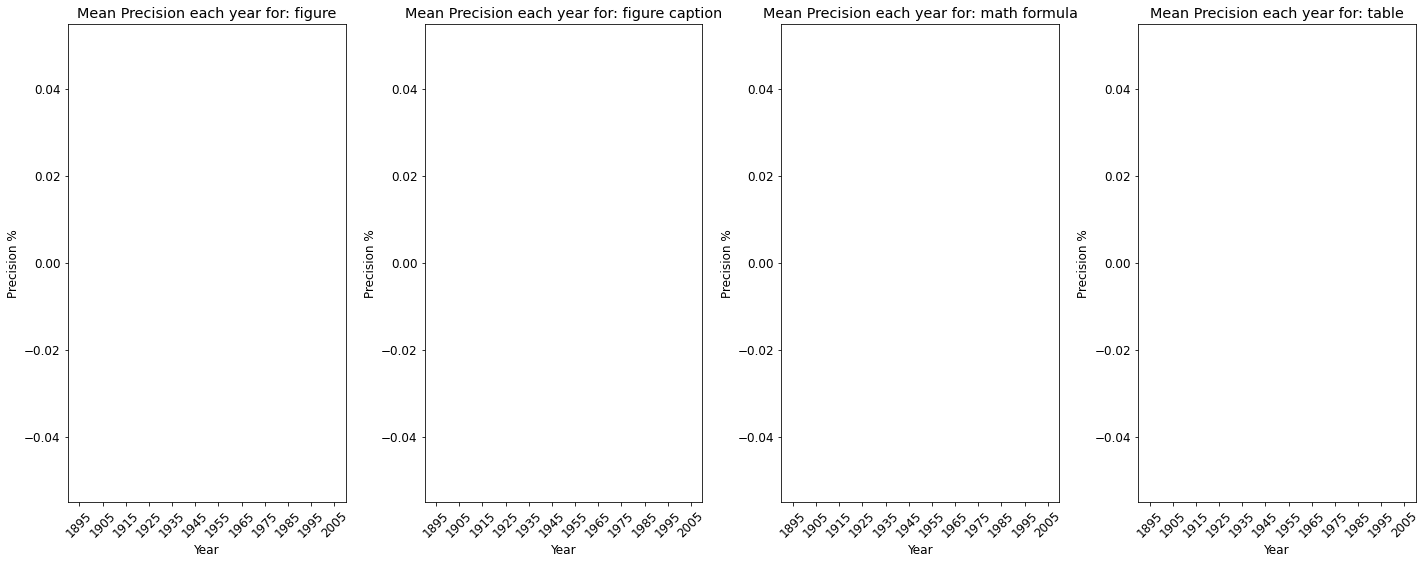

In [42]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    p = tp/(tp+fp); 
    quant = 100*p
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Precision each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

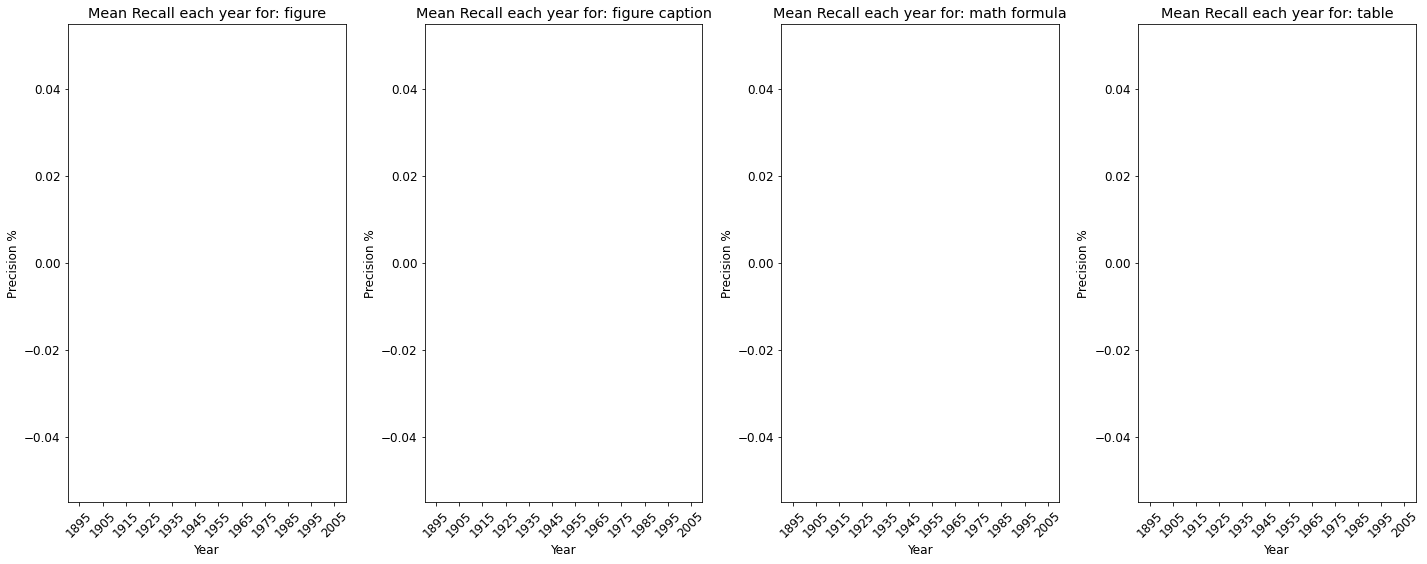

In [43]:
# loop and plot
fig, ax = plt.subplots(1,len(LABELS), figsize=(20,8))

for il,l in enumerate(LABELS):
    r = tp/(tp+fn)
    quant = 100*r
    
    quant.plot(kind='bar',ax=ax[il])
    ax[il].set_xticklabels([x.strftime("%Y") for x in quant.index], rotation=45)
    ax[il].set_title('Mean Recall each year for: ' + l)
    ax[il].set_ylabel('Precision %')
    ax[il].set_xlabel('Year')
plt.tight_layout()
plt.show()

## Save to .dat files if requested

In [ ]:
import os

In [ ]:
# if save_dats:
#     # save too
#     out_num_name = binary_dirs.split('/')[0]+adder_dats
#     num_out_file = config.save_table_dats_dir + out_num_name
#     #ioumin_per_labels = [0.1, 0.6, 0.8, 0.9, 0.95]
#     #if out_num_name != 'main':
#     if not os.path.exists(num_out_file+'/'):
#         os.makedirs(num_out_file+'/')
#     ioumin_per_labels = ioustar # just the one for our decisions
#     num_out_file += '/' + out_num_name
#     # how many labels to save up to?
#     lend = 2

#     # save to file
#     with open(num_out_file + '_score.dat','w') as fnum:
#         print(scorestar, file=fnum, end='')
#     with open(num_out_file + '_ncv.dat','w') as fnum:
#         print(n_folds_cv, file=fnum, end='')


#     TPv, FPv, FNv, totalTruev = calc_base_metrics_allboxes_cv(LABELS,[scorestar],ioustar,
#                                                   truebox3,boxes_sq5,labels_sq5, 
#                                                   scores_sq5,n_folds_cv=n_folds_cv)

#     precision, precision_std, recall, \
#       recall_std, f1, f1_std = calc_prec_rec_f1_cv(TPv,FPv,FNv,
#                                                    LABELS,[scorestar],
#                                                    ioustar)


#     # print out total true
#     for il,m in enumerate(totalTruev[:lend].sum(axis=-1)):
#         with open(num_out_file + '_totTrue_'+LABELS[il].replace(' ','_')+'.dat','w') as fnum:
#             print(int(m), file=fnum, end='')

#     # print out TP
#     for ii,iou in enumerate(ioustar):
#         iouhere = str(iou).replace('.','p')

#         TP = TPv[:,0,ii,:].sum(axis=-1)
#         FP = FPv[:,0,ii,:].sum(axis=-1)
#         FN = FNv[:,0,ii,:].sum(axis=-1)

#         for il,m in enumerate(TP[:lend]):
#             dat = str(round(m/totalTrue[il]*100,1))
#             with open(num_out_file + '_TP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
#                 print(dat, file=fnum, end='')

#         for il,m in enumerate(FP[:lend]):
#             dat = str(round(m/totalTrue[il]*100,1))
#             with open(num_out_file + '_FP_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
#                 print(dat, file=fnum, end='')

#         for il,m in enumerate(FN[:lend]):
#             dat = str(round(m/totalTrue[il]*100,1))
#             with open(num_out_file + '_FN_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
#                 print(dat, file=fnum, end='')

#         for il,m in enumerate(LABELS[:lend]):
#             dat = str(np.round(precision[il,0,ii],1))+'$\pm$' +str(np.round(precision_std[il,0,ii],1))
#             with open(num_out_file + '_prec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
#                 print(dat, file=fnum, end='')

#         for il,m in enumerate(LABELS[:lend]):
#             dat = str(np.round(recall[il,0,ii],1))+'$\pm$' +str(np.round(recall_std[il,0,ii],1))
#             with open(num_out_file + '_rec_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
#                 print(dat, file=fnum, end='')

#         for il,m in enumerate(LABELS[:lend]):
#             dat = str(np.round(f1[il,0,ii],1))+'$\pm$' +str(np.round(f1_std[il,0,ii],1))
#             with open(num_out_file + '_f1_'+LABELS[il].replace(' ','_')+'_iou'+iouhere+'.dat','w') as fnum:
#                 print(dat, file=fnum, end='')


In [ ]:
binary_dirs